## Variational Quantum Thermalizer in Pennylane

In [1]:
# Starts by importing all of the necessary dependencies

import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.optimize import minimize
import random
import math
from tqdm import tqdm

In [2]:
# Defines all necessary variables

beta = 1 #Note that B = 1/T
qubit = 3
qubits = range(qubit)

# Defines the device on which the simulation is run

dev = qml.device("default.qubit", wires=len(qubits))

In [4]:
# Creates the target Hamiltonian matrix

def create_hamiltonian_matrix(n):

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, -1j], [1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])

    matrix = np.zeros((2**n, 2**n))

    for i in range(0, n-1):
        m = 1
        for j in range(0, n):
            if (j == i or j == i+1):
                m = np.kron(m, pauli_x)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)

    for i in range(0, n-1):
        m = 1
        for j in range(0, n):
            if (j == i or j == i+1):
                m = np.kron(m, pauli_y)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)

    for i in range(0, n-1):
        m = 1
        for j in range(0, n):
            if (j == i or j == i+1):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)

    for i in range(0, n):
        m = 1
        for j in range(0, n):
            if (j == i):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)


    return matrix

ham_matrix = create_hamiltonian_matrix(3)
print(ham_matrix)

[[ 5.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j -1.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  2.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j -3.+0.j  2.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j]]


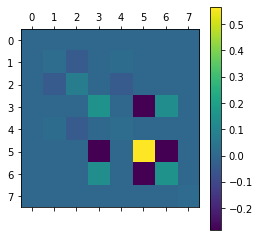

Expectation Value: (-4.617704476259032+0j)
Entropy: (0.5455233906195589+3.1914554620519254e-17j)
Final Cost: (-5.163227866878591-3.1914554620519254e-17j)


In [22]:
#Creates the grid visualization of the density matrices

def create_density_plot(data):

    array = np.array(data)
    plt.matshow(array)
    plt.colorbar()
    plt.show()

# Creates the target density matrix

def create_target(qubit, beta):

    h = create_hamiltonian_matrix(qubit)
    y = -1*float(beta)*h
    new_matrix = scipy.linalg.expm(np.array(y))
    norm = np.trace(new_matrix)
    final_target = (1/norm)*new_matrix

    # Calculates the entropy, the expectation value, and the final cost

    entropy = -1*np.trace(np.matmul(final_target, scipy.linalg.logm(final_target)))
    ev = np.trace(np.matmul(final_target, h))
    real_cost = beta*np.trace(np.matmul(final_target, h)) - entropy

    # Plots the final density matrix

    create_density_plot(final_target.real)

    # Prints the calculated values

    print("Expectation Value: "+str(ev))
    print("Entropy: "+str(entropy))
    print("Final Cost: "+str(real_cost))
    
    return final_target

final_density_matrix = create_target(qubit, beta)

In [6]:
# Creates the probability distribution according to the theta parameters

def sigmoid(x):

    return (math.exp(x) / (math.exp(x) + 1))

# Creates the initial probability distribution

def create_dist(theta_param):

    prob = []
    for i in range(0, len(theta_param)):
        prob.append([sigmoid(theta_param[i]._value), 1-sigmoid(theta_param[i]._value)])

    return prob

def create_new_dist(theta_param):

    prob = []
    for i in range(0, len(theta_param)):
        prob.append([sigmoid(theta_param[i]), 1-sigmoid(theta_param[i])])

    return prob

#Calculate the Von Neumann entropy of the initial density matrices

def calculate_entropy(distribution):

    total_entropy = []
    for i in distribution:
        total_entropy.append(-1*i[0]*np.log(i[0]) + -1*i[1]*np.log(i[1]))
    
    #Returns an array of the entropy values of the different initial density matrices

    return total_entropy

In [11]:
#Creates the initialization unitary for each of the computational basis states

def create_v_gate(prep_state):

    for i in range(0, len(prep_state)):
        if (prep_state[i] == 1):
            qml.PauliX(wires=i)

# Creates the single rotational ansatz

def single_rotation(phi_params, q):

    qml.RZ(phi_params[0], wires=q)
    qml.RY(phi_params[1], wires=q)
    qml.RX(phi_params[2], wires=q)

# Creates the double rotational gates

def rzz(param, qubit1, qubit2):

    qml.CNOT(wires=[qubit1, qubit2])
    qml.RZ(param, wires=qubit2)
    qml.CNOT(wires=[qubit1, qubit2])

def rxx(param, qubit1, qubit2):

    qml.Hadamard(wires=qubit1)
    qml.Hadamard(wires=qubit2)
    rzz(param, qubit1, qubit2)
    qml.Hadamard(wires=qubit1)
    qml.Hadamard(wires=qubit2)

def ryy(param, qubit1, qubit2):

    qml.S(wires=qubit1)
    qml.S(wires=qubit2)
    qml.Hadamard(wires=qubit1)
    qml.Hadamard(wires=qubit2)
    rzz(param, qubit1, qubit2)
    qml.Hadamard(wires=qubit1)
    qml.Hadamard(wires=qubit2) 
    qml.PhaseShift(float(3*math.pi/2), wires=qubit1)
    qml.PhaseShift(float(3*math.pi/2), wires=qubit2)

# Creates the double rotation ansatz

def double_rotation(params, qubit1, qubit2):

    rzz(params[0], qubit1, qubit2)
    rxx(params[1], qubit1, qubit2)
    ryy(params[2], qubit1, qubit2)

In [12]:
# Creates the ansatz circuit

def ansatz_circuit(params, qubits):

    param_list_1 = [[params[0], params[1], params[2]], [params[3], params[4], params[5]]]
    #param_list_2 = [[params[6], params[7], params[8]], [params[9], params[10], params[11]]]
    param_list_3 = [[params[6], params[7], params[8]], [params[9], params[10], params[11]], [params[12], params[13], params[14]]]

    qubits = range(qubit)

    for i in range(0, len(qubits)-1):
        double_rotation(param_list_1[i], i, i+1) 
    
    for i in qubits:
        single_rotation(param_list_3[i], i) 
    
    for i in range(0, len(qubits)-1):
        double_rotation(param_list_1[i], i, i+1)

In [13]:
# Creates the quantum circuit

@qml.qnode(dev)
def quantum_circuit(params, qubits, prob, k):

    # Sample values for each of the qubits

    '''
    samples = []
    for dist in prob:
        sample = list(np.random.choice(2, 1, p=[dist[0].val, dist[1].val]))[0]
        samples.append(sample)
    
    '''
    samples = [int(i) for i in list(bin(int(k.val))[2:].zfill(qubit))]

    # Prepares the initial basis state corresponding to the sample

    create_v_gate(samples)

    # Prepares the variational ansatz for the circuit

    ansatz_circuit(params, qubits)

    # Samples from the variational circuit

    '''
    x_observables = [(qml.PauliX(0) @ qml.PauliX(1)), (qml.PauliX(1) @ qml.PauliX(2))]
    z_observables = [(qml.PauliZ(0) @ qml.PauliZ(1)), (qml.PauliZ(1) @ qml.PauliZ(2))]
    y_observables = [(qml.PauliY(0) @ qml.PauliY(1)), (qml.PauliY(1) @ qml.PauliY(2))]
    other_observables = [qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2)]

    observables = []

    for i  in x_observables:
        observables.append(i)
    
    for i  in z_observables:
        observables.append(i)
    
    for i  in y_observables:
        observables.append(i)
    
    for i  in observables:
        observables.append(i)

    return [qml.sample(i) for i in observables]
    '''

    return qml.expval(qml.Hermitian(ham_matrix, wires=range(qubit)))

In [27]:
# Creates the cost function

def cost_function(params):

    prob = create_dist([params[i] for i in qubits])
    params = params[len(qubits):]

    final_cost = 0
    for k in range(0, 2**qubit):
        s = [int(i) for i in list(bin(k)[2:].zfill(qubit))]
        final_cost += quantum_circuit(params, qubits, prob, k)*prob[0][s[0]]*prob[1][s[1]]*prob[2][s[2]]
    
    #final_cost = final_cost/sam
    entropy = calculate_entropy(prob)
    final_final_cost = beta*final_cost - sum(entropy)

    return final_final_cost

iterations = 0

def num_cost_function(params):
    
    global iterations
    
    prob = create_new_dist([params[i] for i in qubits])
    params = params[len(qubits):]

    final_cost = 0
    for k in range(0, 2**qubit):
        s = [int(i) for i in list(bin(k)[2:].zfill(qubit))]
        final_cost += quantum_circuit(params, qubits, prob, k)*prob[0][s[0]]*prob[1][s[1]]*prob[2][s[2]]
    
    #final_cost = final_cost/sam
    entropy = calculate_entropy(prob)
    final_final_cost = beta*final_cost - sum(entropy)
    
    if (iterations%50 == 0):
        print("Cost at Step "+str(iterations)+": "+str(final_final_cost))
    
    iterations += 1
    
    return final_final_cost 

Cost at Step 0: -1.791995851782956
Cost at Step 50: -3.1282038040322453
Cost at Step 100: -4.237806164418245
Cost at Step 150: -4.598300484157935
Cost at Step 200: -4.7667151421292875
Cost at Step 250: -4.852597633778633
Cost at Step 300: -4.91200820251989
Cost at Step 350: -4.956303388590497
Cost at Step 400: -4.987471241423087
Cost at Step 450: -5.004262736100942
Cost at Step 500: -5.014721559292072
Cost at Step 550: -5.026263684482086
Cost at Step 600: -5.033230084657662
Cost at Step 650: -5.038714805661341
Cost at Step 700: -5.044619763032102
Cost at Step 750: -5.0506256595606995
Cost at Step 800: -5.053433674363735
Cost at Step 850: -5.055563798803676
Cost at Step 900: -5.057626690780377
Cost at Step 950: -5.059706219468551
     fun: -5.061391392840726
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 1000
  status: 2
 success: False
       x: array([-4.12602576e+00,  3.15728523e+00,  2.49455068e+00,  3.07680751e+00,
       -4.95169938e-

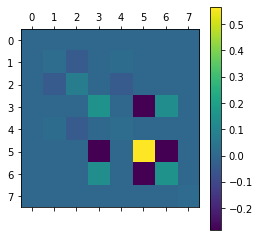

In [28]:
# Creates the optimizer

'''
optimizer = qml.GradientDescentOptimizer(stepsize=1.2)
optimizer = qml.AdamOptimizer(stepsize=0.8)
steps = 200
params = [random.randint(-100, 100)/100 for i in range(0, 18)]

for i in range(0, steps):

    params = optimizer.step(cost_function, params)
    print("Cost Step "+str(i)+": "+str(num_cost_function(params)))

print(params)
'''

params = [random.randint(-100, 100)/100 for i in range(0, 18)]
out = minimize(num_cost_function, x0=params, method="COBYLA", options={'maxiter':1000})
params = out['x']
print(out)

final_density_matrix_2 = np.zeros((2**qubit, 2**qubit))

prob = create_new_dist([params[i] for i in qubits])
params = params[len(qubits):]

for k in range(0, 2**qubit):
    s = [int(i) for i in list(bin(k)[2:].zfill(qubit))]
    quantum_circuit(params, qubits, prob, k)
    state_vector = dev._state
    final_density_matrix_2 = np.add(final_density_matrix_2, prob[0][s[0]]*prob[1][s[1]]*prob[2][s[2]]*np.outer(np.array(state_vector), np.conj(np.array(state_vector))))

print(final_density_matrix_2)

# Finds the trace distance between two density matrices

def trace_distance(one, two):
    
    return 0.5*np.trace(np.absolute(np.add(one, -1*two)))

print("Final Fidelity: "+str(trace_distance(final_density_matrix_2, final_density_matrix)))

create_density_plot(final_density_matrix.real)